In [28]:
!uv pip install mujoco
!uv pip install matplotlib
!uv pip install numpy

Using Python 3.10.4 environment at: /Users/braeden/Development/Yale/cpsc4850/go_on_bot/.venv
Audited 1 package in 15ms
Using Python 3.10.4 environment at: /Users/braeden/Development/Yale/cpsc4850/go_on_bot/.venv
Audited 1 package in 4ms
Using Python 3.10.4 environment at: /Users/braeden/Development/Yale/cpsc4850/go_on_bot/.venv
Audited 1 package in 1ms


In [29]:
import mujoco
import mujoco.viewer
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

In [63]:
model_path = "../ufactory_lite6/lite6.xml"
model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)

cube_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "target_cube")
cube_geom_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, "goal_cube")

In [64]:
def get_end_effector_position(model, data):
    site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, "attachment_site")
    return data.site_xpos[site_id].copy()

def set_joint_positions(model, data, joint_positions):
    data.qpos[:6] = joint_positions[:6]
    data.ctrl[:6] = joint_positions[:6]
    mujoco.mj_forward(model, data)

def add_cube_to_scene(model, data, cube_position, cube_size=0.05):
    return cube_position

def visualize_state(model, data, title="Robot State"):
    renderer = mujoco.Renderer(model, height=480, width=640)
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    pixels = renderer.render()
    
    plt.figure(figsize=(10, 8))
    plt.imshow(pixels)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    return pixels

In [66]:
c_1 = 0.001
c_2 = 0.9

def objective_function(joint_positions, model, data, goal_position):
    set_joint_positions(model, data, joint_positions)
    ee_pos = get_end_effector_position(model, data)
    diff = ee_pos - goal_position
    return 0.5 * np.dot(diff, diff)

def gradient_fd(f, x, epsilon=1e-5):
    g = np.zeros_like(x)
    f_curr = f(x)
    for i in range(len(x)):
        x_p = x.copy()
        x_p[i] += epsilon
        g[i] = (f(x_p) - f_curr) / epsilon
    return g

def line_search(phi, D, zoom, a_initial, a_max, max_iter):
    a_old = a_initial
    a_curr = a_max / 2
    for i in range(1, max_iter):
        if ((phi(a_curr) > phi(0) + c_1*a_curr*D(0)) or
            (i>1 and phi(a_curr) >= phi(a_old))):
            return zoom(phi, D, a_old, a_curr)
        if np.abs(D(a_curr)) <= c_2 * np.abs(D(0)):
            return a_curr
        if D(a_curr) >= 0:
            return zoom(phi, D, a_old, a_curr)
        a_old = a_curr
        a_curr = (a_curr + a_max) / 2
    return None

def bfgs_hessian(hk, sk, yk):
    pk = 1.0 / (np.dot(yk, sk))
    I = np.eye(len(sk))
    a = I - pk * np.outer(sk, yk)
    b = I - pk * np.outer(yk, sk)
    c = pk * np.outer(sk, sk)
    return a @ hk @ b + c

def quasi_newton_descent(model, data, x0, goal_position, threshold=1e-4, max_iter=100, visualize_steps=True):
    xk = np.array(x0)
    hk = np.eye(len(x0))
    obj_history = []
    
    def f(x):
        return objective_function(x, model, data, goal_position)
    
    def grad(x):
        return gradient_fd(f, x)
    
    if visualize_steps:
        set_joint_positions(model, data, xk)
        ee_pos = get_end_effector_position(model, data)
        print(f"Initial state:")
        print(f"  Joint positions: {xk}")
        print(f"  End effector: {ee_pos}")
        print(f"  Goal position: {goal_position}")
        print(f"  Distance to goal: {np.linalg.norm(ee_pos - goal_position):.4f}")
        visualize_state(model, data, "Initial State")
    
    for i in range(max_iter):
        g = grad(xk)
        g_norm = np.linalg.norm(g)
        obj_val = f(xk)
        obj_history.append(obj_val)
        
        if i % 10 == 0:
            set_joint_positions(model, data, xk)
            ee_pos = get_end_effector_position(model, data)
            print(f"Iteration {i}: obj={obj_val:.6f}, grad_norm={g_norm:.6f}, dist={np.linalg.norm(ee_pos - goal_position):.4f}")
        
        if g_norm < threshold:
            print(f"\nConverged at iteration {i}")
            break
        
        pk = -hk @ g
        
        def zoom_func(phi, D, a_low, a_high, max_iter=1000):
            for _ in range(max_iter):
                a_j = (a_low + a_high) / 2
                if (((phi(a_j) > phi(0) + c_1*a_j*D(0))) or
                    phi(a_j) >= phi(a_low)):
                    a_high = a_j
                else:
                    if np.abs(D(a_j)) <= c_2*np.abs(D(0)):
                        return a_j
                    if D(a_j)*(a_high - a_low) >= 0:
                        a_high = a_low
                    a_low = a_j
            return a_j
        
        def phi(alpha):
            return f(xk + alpha * pk)
        
        def D(alpha):
            return np.dot(grad(xk + alpha*pk), pk)
        
        alpha = line_search(phi, D, zoom_func, a_initial=0, a_max=10.0, max_iter=1000)
        if alpha is None:
            print("Line search failed")
            break
        
        xk_old = xk
        xk = xk + alpha * pk
        
        sk = xk - xk_old
        yk = grad(xk) - grad(xk_old)
        hk = bfgs_hessian(hk, sk, yk)
    
    if visualize_steps:
        set_joint_positions(model, data, xk)
        ee_pos = get_end_effector_position(model, data)
        print(f"\nFinal state:")
        print(f"Joint positions: {xk}")
        print(f"End effector: {ee_pos}")
        print(f"Goal position: {goal_position}")
        print(f"Final distance to goal: {np.linalg.norm(ee_pos - goal_position):.4f}")
        visualize_state(model, data, "Final State")
    
    return xk, obj_history

Initial end effector position: [2.27679311e-01 1.78865975e-07 4.68017755e-01]
Robot coordinate system is in meters (MuJoCo units)


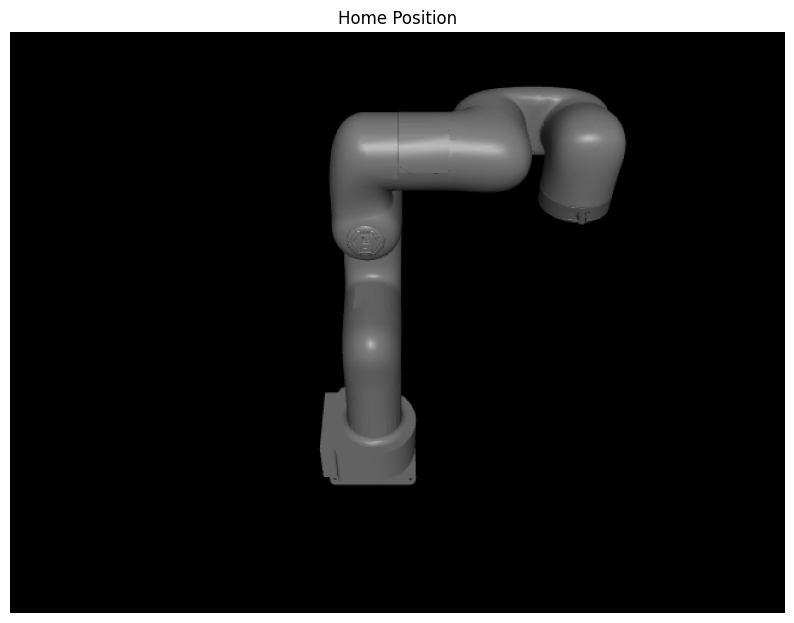

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(480, 640, 3), dtype=uint8)

In [67]:
x0 = np.array([0.0, 0.0, 1.57, 0.0, 1.57, 0.0])
set_joint_positions(model, data, x0)
initial_ee_pos = get_end_effector_position(model, data)
print(f"Initial end effector position: {initial_ee_pos}")
print(f"Robot coordinate system is in meters (MuJoCo units)")
visualize_state(model, data, "Home Position")

Initial state:
  Joint positions: [0.   0.   1.57 0.   1.57 0.  ]
  End effector: [2.27679311e-01 1.78865975e-07 4.68017755e-01]
  Goal position: [0.3 0.2 0.4]
  Distance to goal: 0.2233


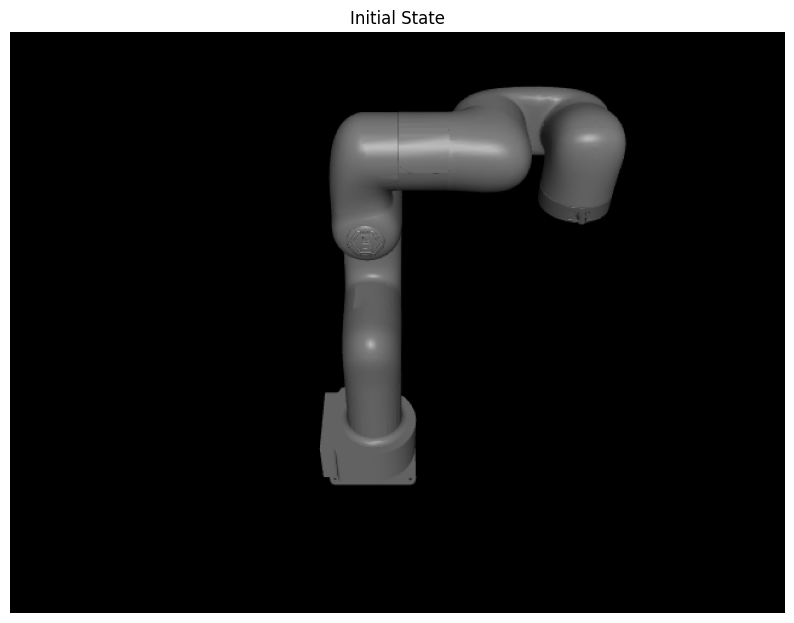

Iteration 0: obj=0.024928, grad_norm=0.059615, dist=0.2233
Iteration 10: obj=0.000011, grad_norm=0.001396, dist=0.0047

Converged at iteration 12

Final state:
  Joint positions: [0.55582703 0.59159423 2.00764149 0.19401037 1.25245494 0.        ]
  End effector: [0.30002177 0.19983255 0.39998858]
  Goal position: [0.3 0.2 0.4]
  Final distance to goal: 0.0002


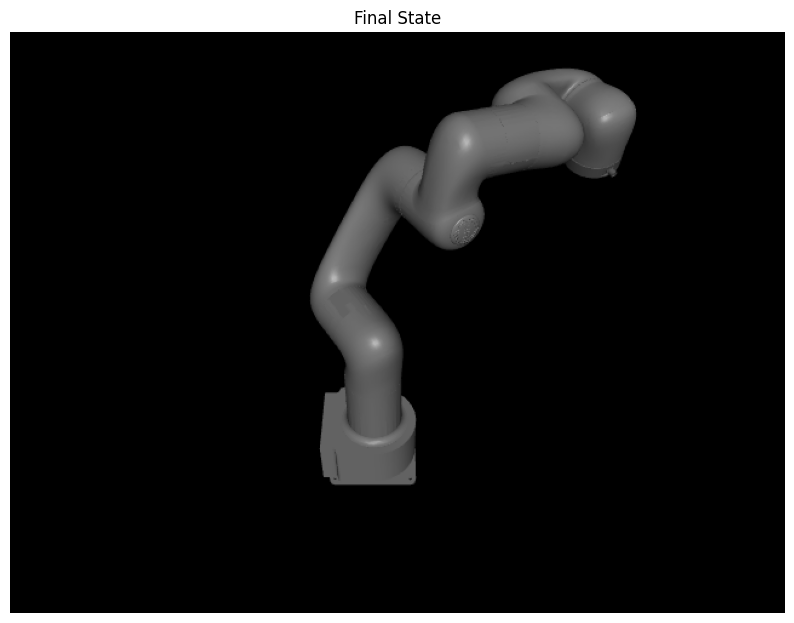

In [34]:
goal_position = np.array([0.3, 0.2, 0.4])

optimal_joints, obj_history = quasi_newton_descent(
    model, data, x0, goal_position, 
    threshold=1e-4, max_iter=100, visualize_steps=True
)

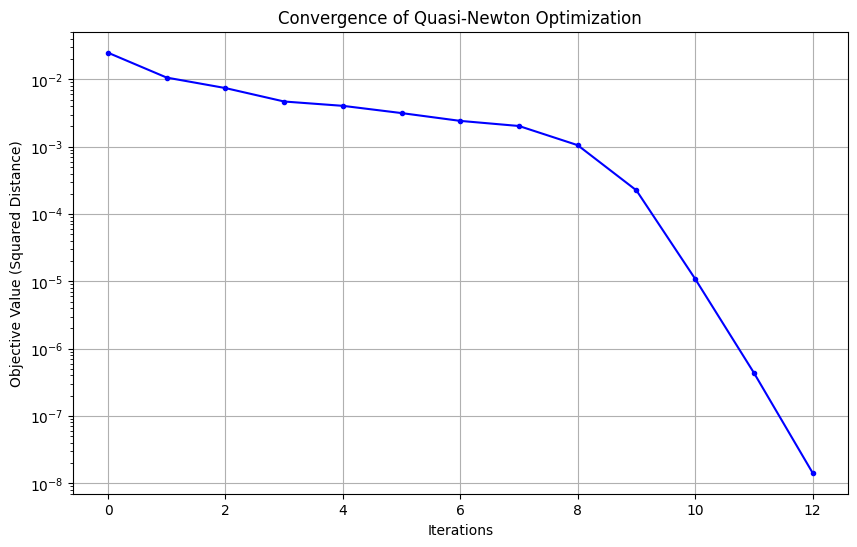


Final objective value: 0.0000000143
Final joint positions: [0.55582703 0.59159423 2.00764149 0.19401037 1.25245494 0.        ]


In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(obj_history)), obj_history, 'b-o', markersize=3)
plt.xlabel("Iterations")
plt.ylabel("Objective Value (Squared Distance)")
plt.title("Convergence of Quasi-Newton Optimization")
plt.grid(True)
plt.yscale('log')
plt.show()

print(f"\nFinal objective value: {obj_history[-1]:.10f}")
print(f"Final joint positions: {optimal_joints}")

In [68]:
cube_position = goal_position  
cube_size = 0.05

In [69]:
# def launch_viewer():
#     set_joint_positions(model, data, optimal_joints)
#     
#     with mujoco.viewer.launch_passive(model, data) as viewer:
#         print("Viewer launched. Close the window to continue.")
#         while viewer.is_running():
#             mujoco.mj_step(model, data)
#             viewer.sync()
#             time.sleep(0.01)
# 
# launch_viewer()

In [71]:
print(f"Initial joint configuration: {x0}")
set_joint_positions(model, data, x0)
print(f"Initial end effector position: {get_end_effector_position(model, data)}")
print(f"Goal position (target): {goal_position}")
print(f"Optimal joint configuration: {optimal_joints}")
set_joint_positions(model, data, optimal_joints)
final_ee_pos = get_end_effector_position(model, data)
print(f"Final end effector position: {final_ee_pos}")
print(f"Final error: {np.linalg.norm(final_ee_pos - goal_position):.6f} meters")
print(f"Optimization iterations: {len(obj_history)}")


Initial joint configuration: [0.   0.   1.57 0.   1.57 0.  ]
Initial end effector position: [2.27679311e-01 1.78865975e-07 4.68017755e-01]
Goal position (target): [0.3 0.2 0.4]
Optimal joint configuration: [0.38460028 0.7279505  2.01140989 0.13444803 1.21320453 0.        ]
Final end effector position: [0.34991878 0.15009936 0.35004566]
Final error: 0.086472 meters
Optimization iterations: 13


Iteration 0: obj=0.028962, grad_norm=0.088531, dist=0.2407
Iteration 10: obj=0.000000, grad_norm=0.000023, dist=0.0002

Converged at iteration 10
Final error: 0.000162 m
Iterations: 11


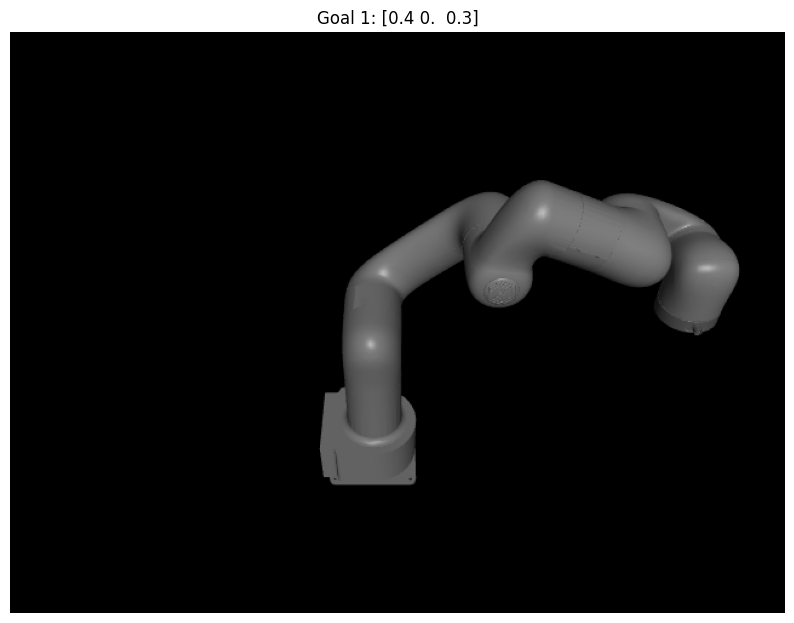

Iteration 0: obj=0.061730, grad_norm=0.098019, dist=0.3514
Iteration 10: obj=0.000133, grad_norm=0.005221, dist=0.0163

Converged at iteration 14
Final error: 0.000065 m
Iterations: 15


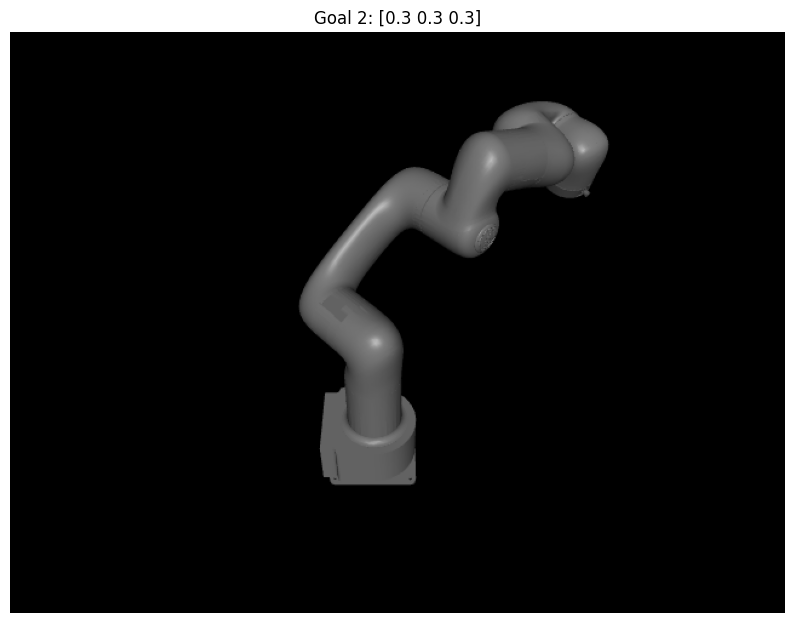

Iteration 0: obj=0.022696, grad_norm=0.050380, dist=0.2131
Iteration 10: obj=0.000082, grad_norm=0.002549, dist=0.0128

Converged at iteration 14
Final error: 0.000113 m
Iterations: 15


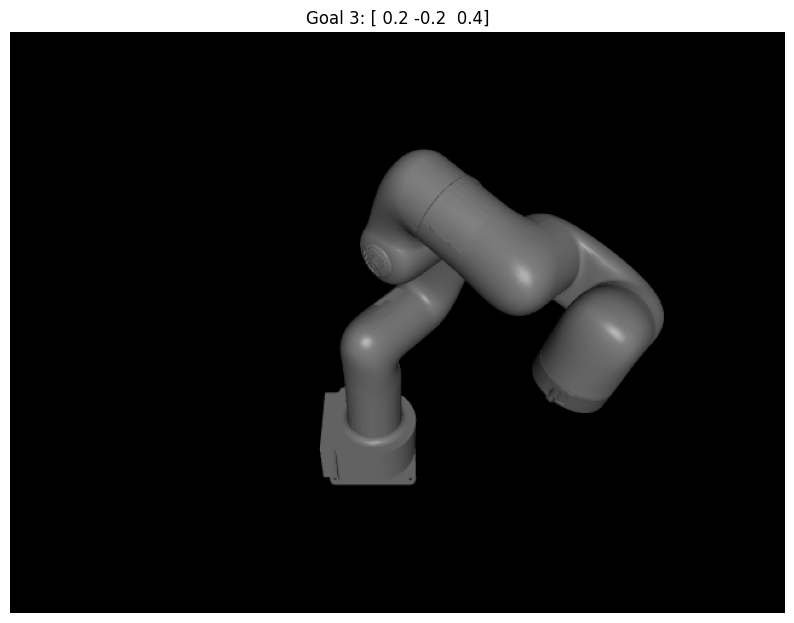

Goal 1: [0.4 0.  0.3] -> Error: 0.000162m, Iters: 11
Goal 2: [0.3 0.3 0.3] -> Error: 0.000065m, Iters: 15
Goal 3: [ 0.2 -0.2  0.4] -> Error: 0.000113m, Iters: 15


In [72]:
test_goals = [
    np.array([0.4, 0.0, 0.3]), 
    np.array([0.3, 0.3, 0.3]),   
    np.array([0.2, -0.2, 0.4]), 
]

results = []

for i, goal in enumerate(test_goals):
    optimal_joints, obj_hist = quasi_newton_descent(
        model, data, x0, goal, 
        threshold=1e-4, max_iter=100, visualize_steps=False
    )
    
    set_joint_positions(model, data, optimal_joints)
    final_pos = get_end_effector_position(model, data)
    error = np.linalg.norm(final_pos - goal)
    
    results.append({
        'goal': goal,
        'joints': optimal_joints,
        'final_pos': final_pos,
        'error': error,
        'iterations': len(obj_hist)
    })
    
    print(f"Final error: {error:.6f} m")
    print(f"Iterations: {len(obj_hist)}")
    visualize_state(model, data, f"Goal {i+1}: {goal}")

for i, result in enumerate(results):
    print(f"Goal {i+1}: {result['goal']} -> Error: {result['error']:.6f}m, Iters: {result['iterations']}")

Cube following circular path with 16 waypoints
Path center: [0.35 0.   0.35], radius: 0.15m

Iteration 0: obj=0.044043, grad_norm=0.095694, dist=0.2968
Iteration 10: obj=0.000401, grad_norm=0.001653, dist=0.0283

Converged at iteration 13
Waypoint  1/16 | Error: 4.89mm | Iters: 14


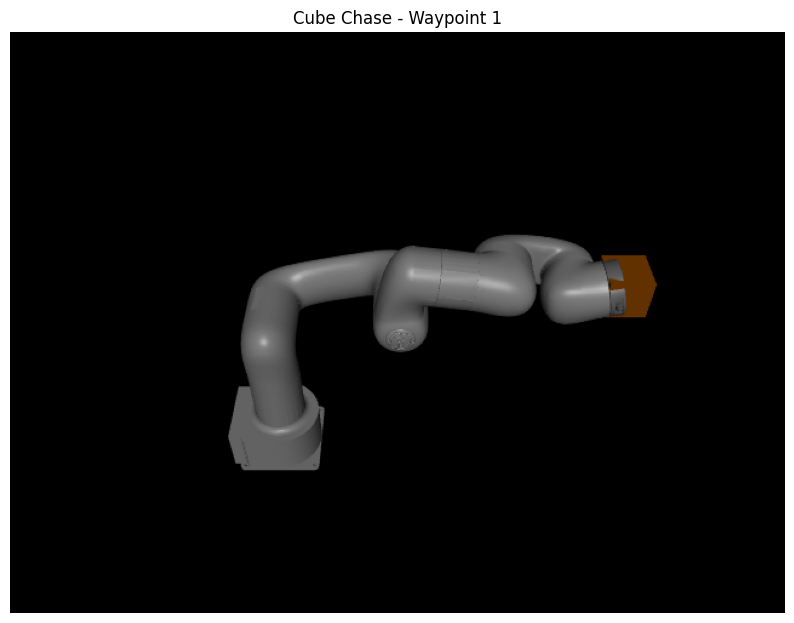

Iteration 0: obj=0.002310, grad_norm=0.035756, dist=0.0680

Converged at iteration 5
Waypoint  2/16 | Error: 5.88mm | Iters:  6
Iteration 0: obj=0.001641, grad_norm=0.027814, dist=0.0573

Converged at iteration 4
Waypoint  3/16 | Error: 12.46mm | Iters:  5
Iteration 0: obj=0.002441, grad_norm=0.020651, dist=0.0699

Converged at iteration 1
Waypoint  4/16 | Error: 53.07mm | Iters:  2
Iteration 0: obj=0.006846, grad_norm=0.016987, dist=0.1170

Converged at iteration 4
Waypoint  5/16 | Error: 110.85mm | Iters:  5


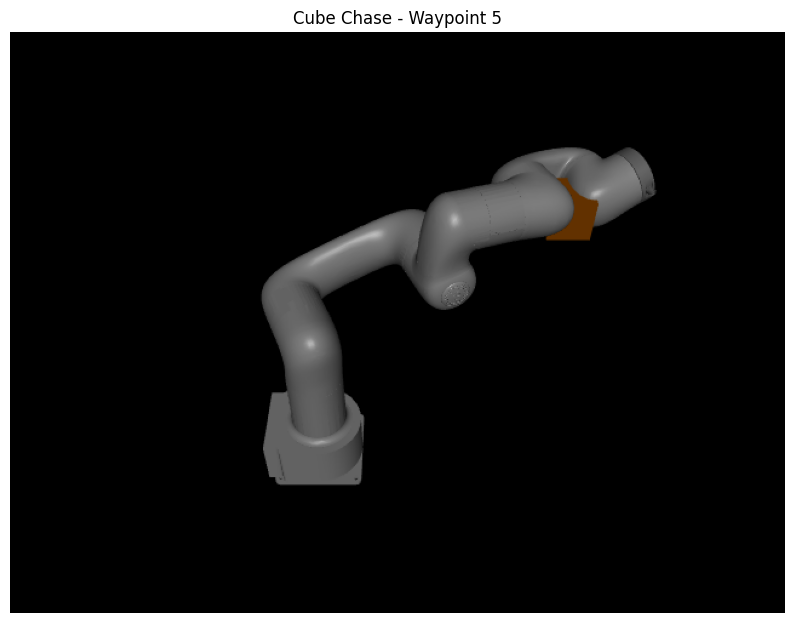

Iteration 0: obj=0.015671, grad_norm=0.012513, dist=0.1770

Converged at iteration 4
Waypoint  6/16 | Error: 174.85mm | Iters:  5
Iteration 0: obj=0.027541, grad_norm=0.004309, dist=0.2347

Converged at iteration 2
Waypoint  7/16 | Error: 234.40mm | Iters:  3
Iteration 0: obj=0.039836, grad_norm=0.021619, dist=0.2823
Iteration 10: obj=0.020875, grad_norm=0.044586, dist=0.2043

Converged at iteration 19
Waypoint  8/16 | Error: 3.39mm | Iters: 20
Iteration 0: obj=0.002300, grad_norm=0.016186, dist=0.0678

Converged at iteration 6
Waypoint  9/16 | Error: 6.24mm | Iters:  7


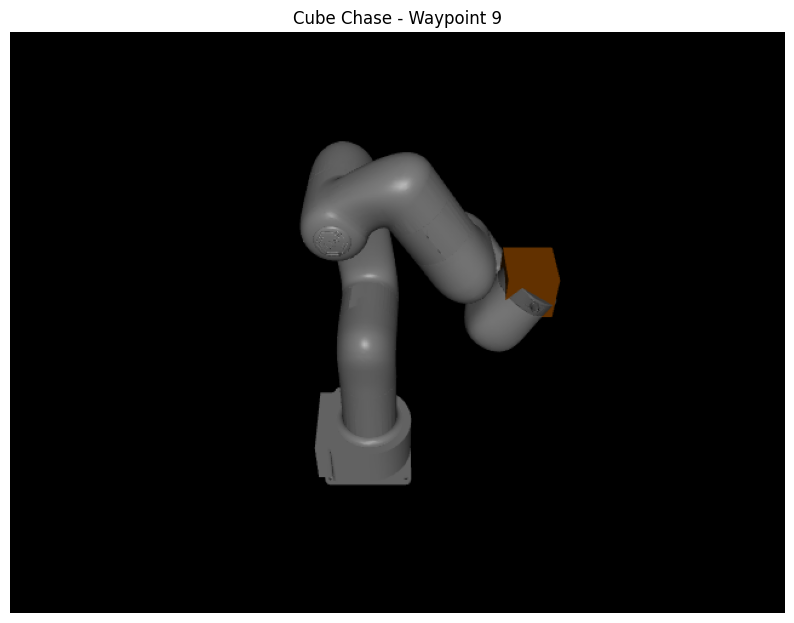

Iteration 0: obj=0.002224, grad_norm=0.016259, dist=0.0667

Converged at iteration 8
Waypoint 10/16 | Error: 2.36mm | Iters:  9
Iteration 0: obj=0.001869, grad_norm=0.011242, dist=0.0611

Converged at iteration 8
Waypoint 11/16 | Error: 2.72mm | Iters:  9
Iteration 0: obj=0.001970, grad_norm=0.014474, dist=0.0628

Converged at iteration 7
Waypoint 12/16 | Error: 1.72mm | Iters:  8
Iteration 0: obj=0.002404, grad_norm=0.021728, dist=0.0693

Converged at iteration 8
Waypoint 13/16 | Error: 1.26mm | Iters:  9


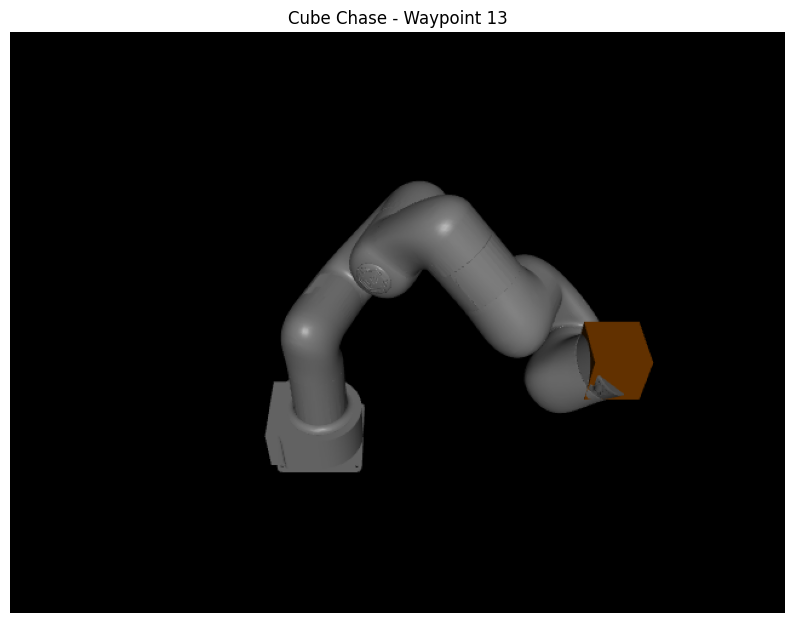

Iteration 0: obj=0.002327, grad_norm=0.024157, dist=0.0682

Converged at iteration 8
Waypoint 14/16 | Error: 0.57mm | Iters:  9
Iteration 0: obj=0.001813, grad_norm=0.022122, dist=0.0602

Converged at iteration 7
Waypoint 15/16 | Error: 1.72mm | Iters:  8
Iteration 0: obj=0.001845, grad_norm=0.027002, dist=0.0607
Iteration 10: obj=0.000001, grad_norm=0.000193, dist=0.0015

Converged at iteration 10
Waypoint 16/16 | Error: 1.49mm | Iters: 11


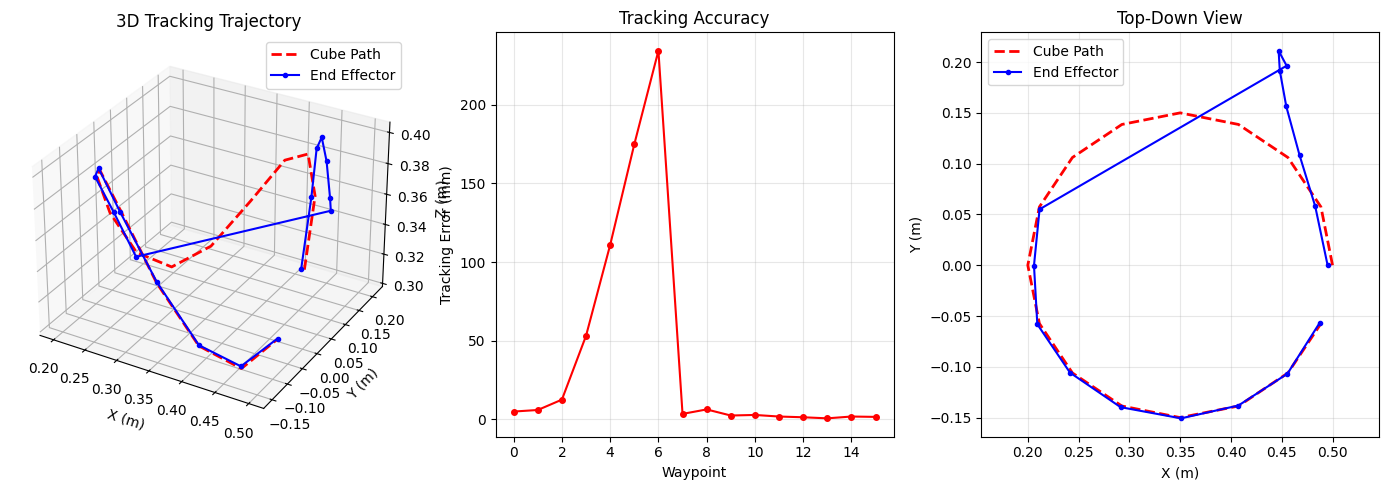

Mean tracking error: 38.62mm
Max tracking error:  234.40mm
Min tracking error:  0.57mm


In [73]:
num_waypoints = 16
radius = 0.15
center = np.array([0.35, 0.0, 0.35])

waypoints = []
for i in range(num_waypoints):
    angle = (i / num_waypoints) * 2 * np.pi
    x = center[0] + radius * np.cos(angle)
    y = center[1] + radius * np.sin(angle)
    z = center[2] + 0.05 * np.sin(2 * angle)  
    waypoints.append(np.array([x, y, z]))

print(f"Cube following circular path with {num_waypoints} waypoints")
print(f"Path center: {center}, radius: {radius}m\n")

joint_configs = []
ee_positions = []
errors = []

current_joints = x0.copy()

for i, cube_pos in enumerate(waypoints):
    cube_color = [1, 0.5, 0, 1] 
    temp_xml = create_scene_with_cube(model_path, cube_pos, 0.03, cube_color)
    model_temp = mujoco.MjModel.from_xml_path(temp_xml)
    data_temp = mujoco.MjData(model_temp)
    
    optimal_joints, obj_hist = quasi_newton_descent(
        model_temp, data_temp, current_joints, cube_pos, 
        threshold=1e-3, max_iter=80, visualize_steps=False
    )
    
    set_joint_positions(model_temp, data_temp, optimal_joints)
    final_pos = get_end_effector_position(model_temp, data_temp)
    error = np.linalg.norm(final_pos - cube_pos)
    
    joint_configs.append(optimal_joints)
    ee_positions.append(final_pos)
    errors.append(error)
    
    current_joints = optimal_joints
    
    print(f"Waypoint {i+1:2d}/{num_waypoints} | Error: {error*1000:.2f}mm | Iters: {len(obj_hist):2d}")
    
    if i % 4 == 0:
        visualize_state(model_temp, data_temp, f"Cube Chase - Waypoint {i+1}")
    
    os.unlink(temp_xml)

ee_positions = np.array(ee_positions)
waypoints = np.array(waypoints)

fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], 'r--', label='Cube Path', linewidth=2)
ax1.plot(ee_positions[:, 0], ee_positions[:, 1], ee_positions[:, 2], 'b-o', label='End Effector', markersize=3)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('3D Tracking Trajectory')
ax1.legend()

ax2 = fig.add_subplot(132)
ax2.plot(range(len(errors)), np.array(errors) * 1000, 'r-o', markersize=4)
ax2.set_xlabel('Waypoint')
ax2.set_ylabel('Tracking Error (mm)')
ax2.set_title('Tracking Accuracy')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(133)
ax3.plot(waypoints[:, 0], waypoints[:, 1], 'r--', label='Cube Path', linewidth=2)
ax3.plot(ee_positions[:, 0], ee_positions[:, 1], 'b-o', label='End Effector', markersize=3)
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_title('Top-Down View')
ax3.axis('equal')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean tracking error: {np.mean(errors)*1000:.2f}mm")
print(f"Max tracking error:  {np.max(errors)*1000:.2f}mm")
print(f"Min tracking error:  {np.min(errors)*1000:.2f}mm")


In [74]:
class Vertex:
    def __init__(self, state):
        self.state = np.array(state)
        self.parent = None
        self.cost = 0.0 

class VertexListKDTree:
    def __init__(self, dim):
        self.dim = dim
        self.vertices = []
        self.nn = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
        self.states = None
        
    def add_vertex(self, vertex):
        self.vertices.append(vertex)
        if len(self.vertices) > 0:
            self.states = np.array([v.state for v in self.vertices])
            if len(self.vertices) == 1:
                self.nn.fit(self.states.reshape(1, -1))
            else:
                self.nn.fit(self.states)
        return vertex
    
    def get_closest_vertex_in_graph(self, state):
        if len(self.vertices) == 0:
            return None, float('inf')
        
        state = np.array(state).reshape(1, -1)
        distances, indices = self.nn.kneighbors(state)
        closest_idx = indices[0][0]
        closest_vertex = self.vertices[closest_idx]
        closest_distance = distances[0][0]
        
        return closest_vertex, closest_distance
    
    def get_k_nearest_vertices(self, state, k):
        if len(self.vertices) == 0:
            return [], []
        
        k = min(k, len(self.vertices))
        state = np.array(state).reshape(1, -1)
        
        # temp set n_neighbors for this query
        nn_temp = NearestNeighbors(n_neighbors=k, algorithm='kd_tree', metric='euclidean')
        nn_temp.fit(self.states)
        
        distances, indices = nn_temp.kneighbors(state)
        
        near_vertices = [self.vertices[i] for i in indices[0]]
        near_distances = distances[0].tolist()
        
        return near_vertices, near_distances

def distance(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))

def steer(from_state, to_state, step_size=0.1):
    from_state = np.array(from_state)
    to_state = np.array(to_state)
    dir_vec = to_state - from_state
    norm = np.linalg.norm(dir_vec)
    if norm < step_size:
        return to_state
    return from_state + (dir_vec / norm) * step_size

def collision_free_path(from_state, to_state, num_checks=5):
    for alpha in np.linspace(0, 1, num_checks):
        interp = from_state + alpha * (to_state - from_state)
        if is_state_in_collision(interp):
            return False
    return True

def rrt_star_plan(start, goal, max_iters=1000, step_size=0.1, goal_radius=0.1, 
                  rewire_radius=0.5, collision_checks=3):
    """
    RRT* planner for xArm robot (produces smoother, more optimal paths)
    
    Args:
        start: Start joint angles [q1, q2, q3, q4, q5, q6]
        goal: Goal joint angles [q1, q2, q3, q4, q5, q6]
        max_iters: Maximum number of iterations
        step_size: Maximum step size for steering (radians)
        goal_radius: Radius around goal to consider as reached (radians)
        rewire_radius: Radius for rewiring neighbors (radians)
        collision_checks: Number of collision checks along path
    
    Returns:
        vertex_list: VertexListKDTree containing all vertices
        goal_vertex: Vertex at goal (or None if failed)
    """
    vertex_list = VertexListKDTree(dim=NUM_JOINTS)

    start_vertex = vertex_list.add_vertex(Vertex(start))
    start_vertex.parent = None
    start_vertex.cost = 0.0

    best_goal_vertex = None
    best_goal_cost = float('inf')
    
    for it in range(max_iters):
        if it % 100 == 0:
            print(f"Iteration {it}/{max_iters}, Tree size: {len(vertex_list.vertices)}, " +
                  f"Best goal cost: {best_goal_cost:.3f}")
        
        if np.random.rand() < 0.05:
            x_rand = goal
        else:
            x_rand = sample_feasible_state()

        nearest_vertex, _ = vertex_list.get_closest_vertex_in_graph(x_rand)
        if nearest_vertex is None:
            continue
        x_nearest = nearest_vertex.state

        x_new = steer(x_nearest, x_rand, step_size)

        # check collisions
        # if is_state_in_collision(x_new):
        #     continue
        
        # if not collision_free_path(x_nearest, x_new, num_checks=collision_checks):
        #     continue
        
        # find nearby vertices for connection and rewiring, calc near radius based on tree size w/ RRT* optimal formula
        n = len(vertex_list.vertices)
        near_radius = min(rewire_radius, step_size * np.power(np.log(n + 1) / (n + 1), 1.0 / NUM_JOINTS))
        k_nearest = int(np.ceil(np.log(n + 1)))
        
        near_vertices, near_distances = vertex_list.get_k_nearest_vertices(x_new, k_nearest)
        
        # filter vertices within near_radius
        near_vertices = [v for v, d in zip(near_vertices, near_distances) if d < near_radius]
        
        # choose parent with minimum cost
        min_cost = nearest_vertex.cost + distance(x_nearest, x_new)
        best_parent = nearest_vertex
        
        for near_vertex in near_vertices:
            potential_cost = near_vertex.cost + distance(near_vertex.state, x_new)
            if potential_cost < min_cost:
                if collision_free_path(near_vertex.state, x_new, num_checks=collision_checks):
                    min_cost = potential_cost
                    best_parent = near_vertex
        
        # add new vertex with best parent
        new_vertex = vertex_list.add_vertex(Vertex(x_new))
        new_vertex.parent = best_parent
        new_vertex.cost = min_cost
        
        # rewire nearby vertices if routing through new vertex is cheaper
        for near_vertex in near_vertices:
            if near_vertex == best_parent:
                continue
            
            new_cost = new_vertex.cost + distance(x_new, near_vertex.state)
            if new_cost < near_vertex.cost:
                if collision_free_path(x_new, near_vertex.state, num_checks=collision_checks):
                    near_vertex.parent = new_vertex
                    near_vertex.cost = new_cost
                    # note: In full RRT*, we would propagate cost updates to descendants
                    # for efficiency, we skip this here
        
        # check if we reached the goal region
        dist_to_goal = distance(x_new, goal)
        if dist_to_goal < goal_radius:
            # check if this is better than previous goal connection
            potential_goal_cost = new_vertex.cost + dist_to_goal
            if potential_goal_cost < best_goal_cost:
                if best_goal_vertex is None:
                    print(f"Goal reached in {it} iterations!")
                    goal_vertex = vertex_list.add_vertex(Vertex(goal))
                    goal_vertex.parent = new_vertex
                    goal_vertex.cost = potential_goal_cost
                    best_goal_vertex = goal_vertex
                    best_goal_cost = potential_goal_cost
                else:
                    # rewire goal to better parent
                    print(f"Improved path! Cost: {best_goal_cost:.3f} -> {potential_goal_cost:.3f}")
                    best_goal_vertex.parent = new_vertex
                    best_goal_vertex.cost = potential_goal_cost
                    best_goal_cost = potential_goal_cost

    if best_goal_vertex is not None:
        print(f"\nFinal path cost: {best_goal_cost:.3f}")
        return vertex_list, best_goal_vertex
    else:
        print(f"\nFailed to find path after {max_iters} iterations")
        return vertex_list, None

def reconstruct_path(curr_vertex):
    if curr_vertex is None:
        return []
    
    out = [curr_vertex.state]
    while curr_vertex.parent is not None:
        out.append(curr_vertex.parent.state)
        curr_vertex = curr_vertex.parent
    return out[::-1]

def smooth_path(path, max_iterations=50, collision_checks=10):
    if len(path) <= 2:
        return path
    
    smoothed = path.copy()

    # try to smooth path with shortcutting
    for _ in range(max_iterations):
        if len(smoothed) <= 2:
            break
        
        i = np.random.randint(0, len(smoothed) - 2)
        j = np.random.randint(i + 2, len(smoothed))
        
        if collision_free_path(smoothed[i], smoothed[j], num_checks=collision_checks):
                smoothed = smoothed[:i+1] + smoothed[j:]
    
    print(f"Path smoothing: {len(path)} -> {len(smoothed)} waypoints")
    return smoothed

Target cube position: [0.35 0.2  0.35]

Solving IK for goal configuration...
Iteration 0: obj=0.034445, grad_norm=0.078300, dist=0.2625
Iteration 10: obj=0.000948, grad_norm=0.011963, dist=0.0435

Converged at iteration 14
Goal joint config: [0.493 0.833 2.17  0.187 1.129 0.   ]
Goal EE position: [0.34981505 0.20003447 0.35000016]
Target error: 0.19mm

Planning path with RRT...
Goal reached in 29 iterations!

Path found with 8 waypoints
Tree explored 29 nodes


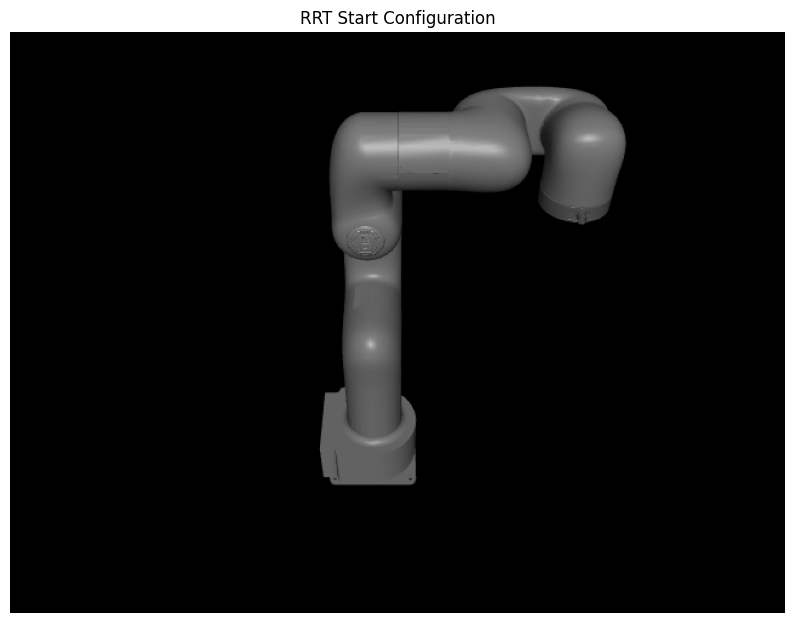

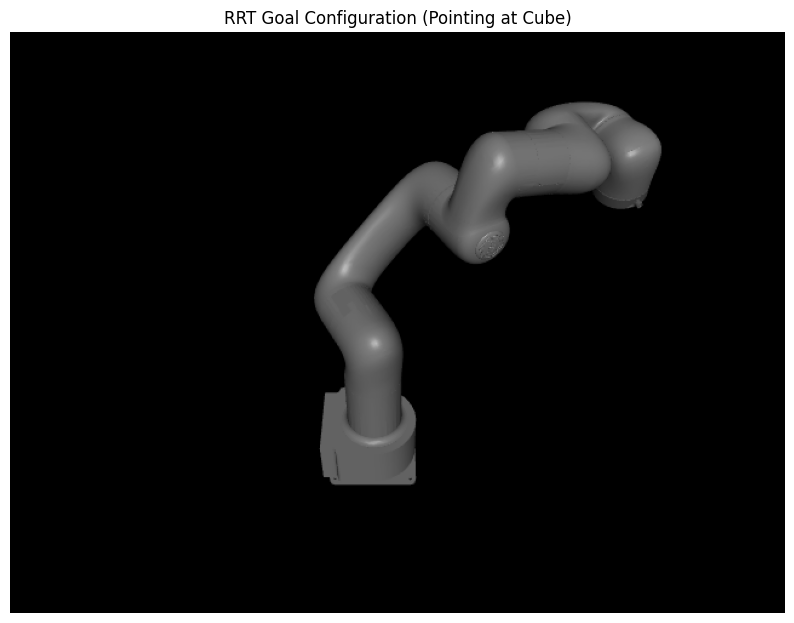

In [75]:
class RRTPlanner:
    def __init__(self, model, data, start_config, goal_config, max_iterations=1000, step_size=0.1):
        self.model = model
        self.data = data
        self.start = np.array(start_config)
        self.goal = np.array(goal_config)
        self.max_iterations = max_iterations
        self.step_size = step_size
        self.tree = {0: {'config': self.start, 'parent': None}}
        self.node_count = 1
        
    def sample_config(self):
        config = np.zeros(6)
        for i in range(6):
            config[i] = np.random.uniform(
                self.model.jnt_range[i, 0], 
                self.model.jnt_range[i, 1]
            )
        return config
    
    def nearest_node(self, config):
        min_dist = float('inf')
        nearest_idx = 0
        for idx, node in self.tree.items():
            dist = np.linalg.norm(node['config'] - config)
            if dist < min_dist:
                min_dist = dist
                nearest_idx = idx
        return nearest_idx, self.tree[nearest_idx]['config']
    
    def steer(self, from_config, to_config):
        direction = to_config - from_config
        dist = np.linalg.norm(direction)
        if dist < self.step_size:
            return to_config
        else:
            return from_config + (direction / dist) * self.step_size
    
    def is_collision_free(self, config):
        for i in range(6):
            if config[i] < self.model.jnt_range[i, 0] or config[i] > self.model.jnt_range[i, 1]:
                return False
        return True
    
    def plan(self):
        for iteration in range(self.max_iterations):
            if np.random.rand() < 0.9:
                rand_config = self.sample_config()
            else:
                rand_config = self.goal
            
            nearest_idx, nearest_config = self.nearest_node(rand_config)
            
            new_config = self.steer(nearest_config, rand_config)
            
            if not self.is_collision_free(new_config):
                continue
            
            self.tree[self.node_count] = {
                'config': new_config,
                'parent': nearest_idx
            }
            
            if np.linalg.norm(new_config - self.goal) < self.step_size:
                self.tree[self.node_count + 1] = {
                    'config': self.goal,
                    'parent': self.node_count
                }
                print(f"Goal reached in {iteration + 1} iterations!")
                return self.extract_path(self.node_count + 1)
            
            self.node_count += 1
        
        print(f"Max iterations reached. Finding closest node to goal...")
        # Find closest node to goal
        closest_idx, _ = self.nearest_node(self.goal)
        return self.extract_path(closest_idx)
    
    def extract_path(self, goal_idx):
        path = []
        current_idx = goal_idx
        while current_idx is not None:
            path.append(self.tree[current_idx]['config'])
            current_idx = self.tree[current_idx]['parent']
        return path[::-1]

cube_pos = np.array([0.35, 0.2, 0.35])
print(f"Target cube position: {cube_pos}")

print("\nSolving IK for goal configuration...")
goal_joints, _ = quasi_newton_descent(
    model, data, x0, cube_pos, 
    threshold=1e-4, max_iter=100, visualize_steps=False
)

set_joint_positions(model, data, goal_joints)
goal_ee_pos = get_end_effector_position(model, data)
print(f"Goal joint config: {np.round(goal_joints, 3)}")
print(f"Goal EE position: {goal_ee_pos}")
print(f"Target error: {np.linalg.norm(goal_ee_pos - cube_pos)*1000:.2f}mm")
print("\nPlanning path with RRT...")
start_config = x0.copy()
rrt = RRTPlanner(model, data, start_config, goal_joints, max_iterations=2000, step_size=0.3)
path = rrt.plan()

print(f"\nPath found with {len(path)} waypoints")
print(f"Tree explored {rrt.node_count} nodes")

set_joint_positions(model, data, start_config)
visualize_state(model, data, "RRT Start Configuration")

set_joint_positions(model, data, goal_joints)
visualize_state(model, data, "RRT Goal Configuration (Pointing at Cube)")

print("\n" + "=" * 60)

Path Statistics:
Waypoints: 8
Total joint space distance: 1.947 rad
Total end effector distance: 0.384 m
Average step size (joint): 0.278 rad
Average step size (EE): 0.055 m


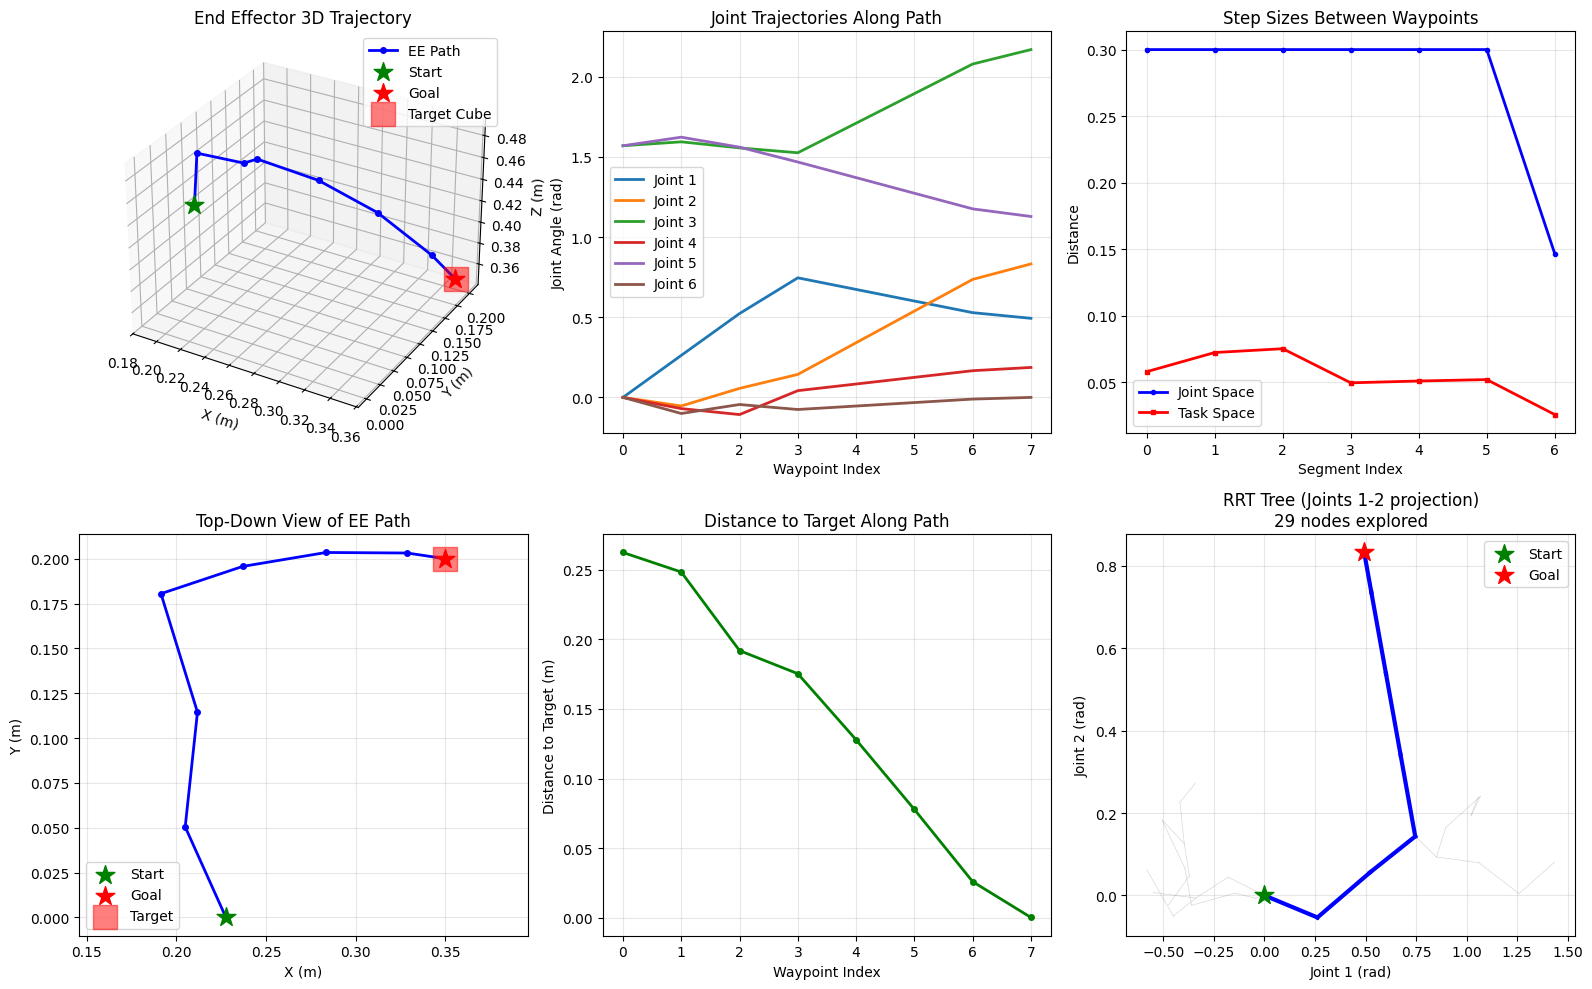

In [76]:

ee_trajectory = []
for config in path:
    set_joint_positions(model, data, config)
    ee_pos = get_end_effector_position(model, data)
    ee_trajectory.append(ee_pos)

ee_trajectory = np.array(ee_trajectory)
path_configs = np.array(path)
joint_distances = []
ee_distances = []

for i in range(len(path) - 1):
    joint_dist = np.linalg.norm(path_configs[i+1] - path_configs[i])
    ee_dist = np.linalg.norm(ee_trajectory[i+1] - ee_trajectory[i])
    joint_distances.append(joint_dist)
    ee_distances.append(ee_dist)

total_joint_distance = np.sum(joint_distances)
total_ee_distance = np.sum(ee_distances)

print(f"Path Statistics:")
print(f"Waypoints: {len(path)}")
print(f"Total joint space distance: {total_joint_distance:.3f} rad")
print(f"Total end effector distance: {total_ee_distance:.3f} m")
print(f"Average step size (joint): {np.mean(joint_distances):.3f} rad")
print(f"Average step size (EE): {np.mean(ee_distances):.3f} m")

fig = plt.figure(figsize=(16, 10))

ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax1.plot(ee_trajectory[:, 0], ee_trajectory[:, 1], ee_trajectory[:, 2], 
         'b-o', markersize=4, linewidth=2, label='EE Path')
ax1.scatter(ee_trajectory[0, 0], ee_trajectory[0, 1], ee_trajectory[0, 2], 
            c='green', s=200, marker='*', label='Start', zorder=5)
ax1.scatter(ee_trajectory[-1, 0], ee_trajectory[-1, 1], ee_trajectory[-1, 2], 
            c='red', s=200, marker='*', label='Goal', zorder=5)
ax1.scatter(cube_pos[0], cube_pos[1], cube_pos[2], 
            c='red', s=300, marker='s', alpha=0.5, label='Target Cube', zorder=5)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('End Effector 3D Trajectory')
ax1.legend()

ax2 = fig.add_subplot(2, 3, 2)
for i in range(6):
    joint_vals = [config[i] for config in path]
    ax2.plot(joint_vals, label=f'Joint {i+1}', linewidth=2)
ax2.set_xlabel('Waypoint Index')
ax2.set_ylabel('Joint Angle (rad)')
ax2.set_title('Joint Trajectories Along Path')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(joint_distances, 'b-o', markersize=3, label='Joint Space', linewidth=2)
ax3.plot(ee_distances, 'r-s', markersize=3, label='Task Space', linewidth=2)
ax3.set_xlabel('Segment Index')
ax3.set_ylabel('Distance')
ax3.set_title('Step Sizes Between Waypoints')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(ee_trajectory[:, 0], ee_trajectory[:, 1], 'b-o', markersize=4, linewidth=2)
ax4.scatter(ee_trajectory[0, 0], ee_trajectory[0, 1], c='green', s=200, marker='*', label='Start', zorder=5)
ax4.scatter(ee_trajectory[-1, 0], ee_trajectory[-1, 1], c='red', s=200, marker='*', label='Goal', zorder=5)
ax4.scatter(cube_pos[0], cube_pos[1], c='red', s=300, marker='s', alpha=0.5, label='Target', zorder=5)
ax4.set_xlabel('X (m)')
ax4.set_ylabel('Y (m)')
ax4.set_title('Top-Down View of EE Path')
ax4.axis('equal')
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(2, 3, 5)
distances_to_goal = [np.linalg.norm(ee_pos - cube_pos) for ee_pos in ee_trajectory]
ax5.plot(distances_to_goal, 'g-o', markersize=4, linewidth=2)
ax5.set_xlabel('Waypoint Index')
ax5.set_ylabel('Distance to Target (m)')
ax5.set_title('Distance to Target Along Path')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(2, 3, 6)
for idx, node in rrt.tree.items():
    if node['parent'] is not None:
        parent = rrt.tree[node['parent']]
        ax6.plot([parent['config'][0], node['config'][0]], 
                [parent['config'][1], node['config'][1]], 
                'gray', alpha=0.3, linewidth=0.5)

for i in range(len(path) - 1):
    ax6.plot([path[i][0], path[i+1][0]], 
            [path[i][1], path[i+1][1]], 
            'b-', linewidth=3)

ax6.scatter(start_config[0], start_config[1], c='green', s=200, marker='*', label='Start', zorder=5)
ax6.scatter(goal_joints[0], goal_joints[1], c='red', s=200, marker='*', label='Goal', zorder=5)
ax6.set_xlabel('Joint 1 (rad)')
ax6.set_ylabel('Joint 2 (rad)')
ax6.set_title(f'RRT Tree (Joints 1-2 projection)\n{rrt.node_count} nodes explored')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Target position: [0.35 0.15 0.35]
Start configuration: [0.   0.   1.57 0.   1.57 0.  ]

METHOD 1: Direct IK (Quasi-Newton)
Iteration 0: obj=0.025695, grad_norm=0.071801, dist=0.2267
Iteration 10: obj=0.000003, grad_norm=0.000884, dist=0.0022

Converged at iteration 12
Time: 8.99ms
Iterations: 13
Final error: 0.14mm
Joint space distance: 1.009 rad

METHOD 2: RRT Planning
----------------------------------------
Goal reached in 48 iterations!
Time: 2.39ms
Waypoints: 6
Nodes explored: 48
Path length: 1.207 rad


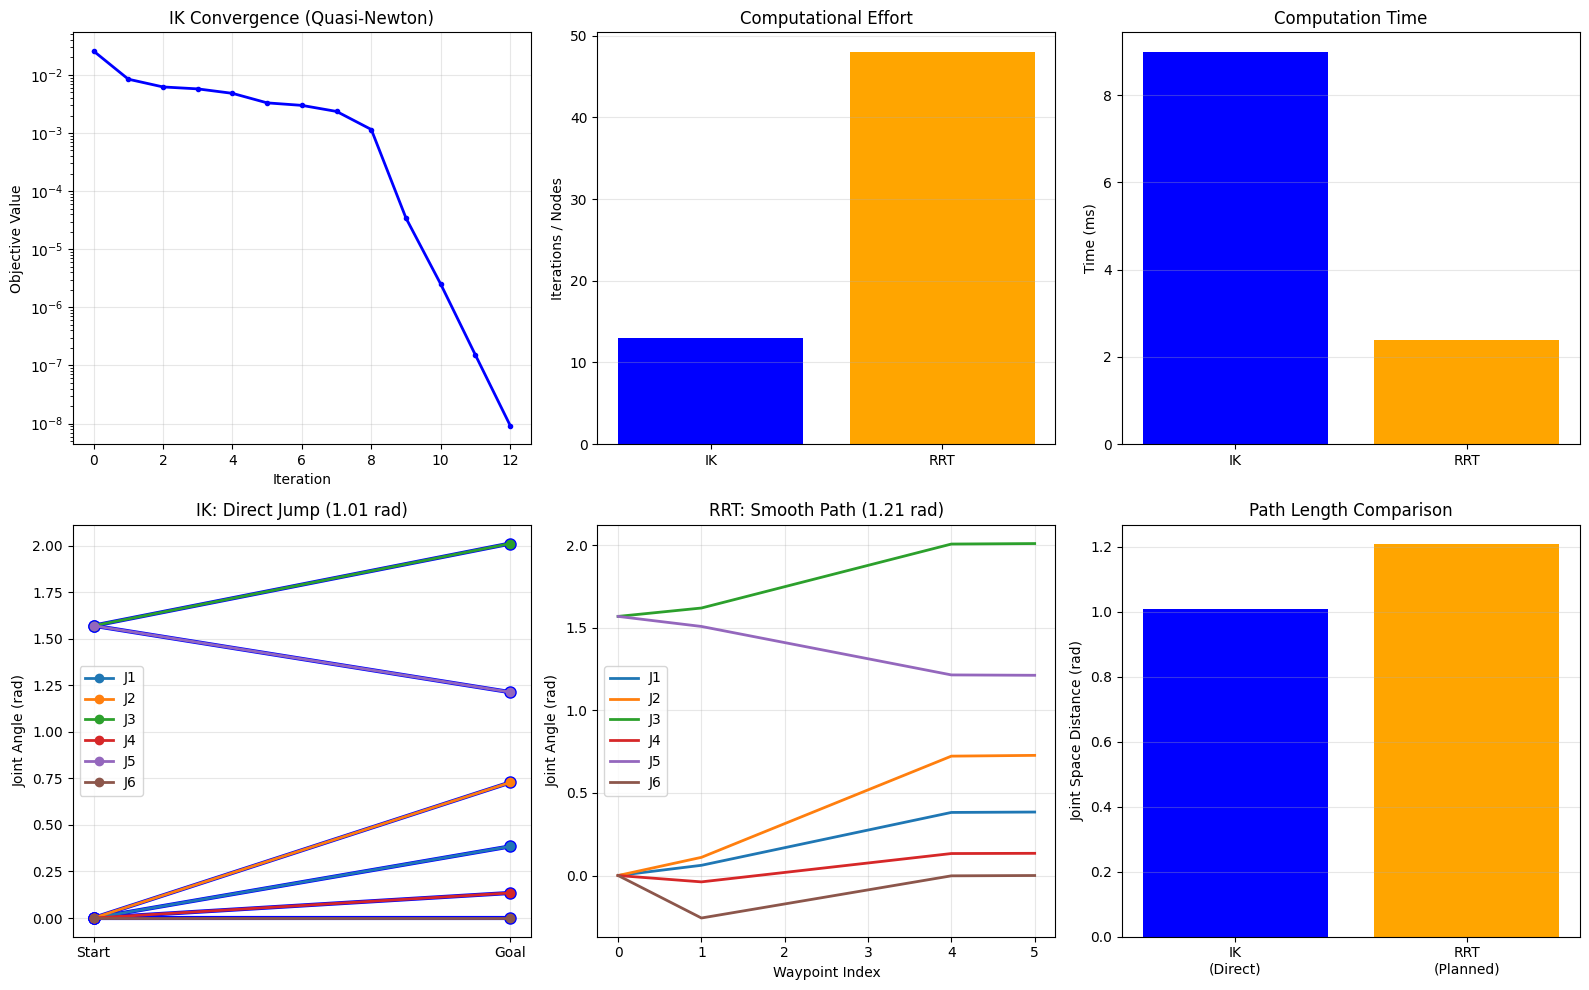

COMPARISON:
IK is 0.3x faster than RRT
IK uses 83.6% of RRT's path length
RRT provides smooth 6 waypoint path vs IK's direct jump
RRT explored 48 configurations vs IK's 13 iterations


In [77]:
import time

target_pos = np.array([0.35, 0.15, 0.35])
start_config = x0.copy()

print(f"Target position: {target_pos}")
print(f"Start configuration: {np.round(start_config, 3)}\n")

print("METHOD 1: Direct IK (Quasi-Newton)")
ik_start_time = time.time()
ik_goal, ik_hist = quasi_newton_descent(
    model, data, start_config, target_pos, 
    threshold=1e-4, max_iter=100, visualize_steps=False
)
ik_time = time.time() - ik_start_time
set_joint_positions(model, data, ik_goal)
ik_ee_pos = get_end_effector_position(model, data)
ik_error = np.linalg.norm(ik_ee_pos - target_pos)
ik_joint_distance = np.linalg.norm(ik_goal - start_config)

print(f"Time: {ik_time*1000:.2f}ms")
print(f"Iterations: {len(ik_hist)}")
print(f"Final error: {ik_error*1000:.2f}mm")
print(f"Joint space distance: {ik_joint_distance:.3f} rad")

print("\nMETHOD 2: RRT Planning")
print("-" * 40)
rrt_start_time = time.time()
rrt = RRTPlanner(model, data, start_config, ik_goal, 
                 max_iterations=2000, step_size=0.3)
rrt_path = rrt.plan()
rrt_time = time.time() - rrt_start_time

rrt_path_configs = np.array(rrt_path)
rrt_joint_distance = np.sum([np.linalg.norm(rrt_path_configs[i+1] - rrt_path_configs[i]) 
                             for i in range(len(rrt_path_configs) - 1)])

print(f"Time: {rrt_time*1000:.2f}ms")
print(f"Waypoints: {len(rrt_path)}")
print(f"Nodes explored: {rrt.node_count}")
print(f"Path length: {rrt_joint_distance:.3f} rad")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes[0, 0].plot(ik_hist, 'b-o', markersize=3, linewidth=2)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Objective Value')
axes[0, 0].set_title('IK Convergence (Quasi-Newton)')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].bar(['IK', 'RRT'], [len(ik_hist), rrt.node_count], color=['blue', 'orange'])
axes[0, 1].set_ylabel('Iterations / Nodes')
axes[0, 1].set_title('Computational Effort')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 2].bar(['IK', 'RRT'], [ik_time*1000, rrt_time*1000], color=['blue', 'orange'])
axes[0, 2].set_ylabel('Time (ms)')
axes[0, 2].set_title('Computation Time')
axes[0, 2].grid(True, alpha=0.3, axis='y')
axes[1, 0].plot([0, 1], [start_config, ik_goal], 'b-o', linewidth=3, markersize=8)
for i in range(6):
    axes[1, 0].plot([0, 1], [start_config[i], ik_goal[i]], 
                   'o-', linewidth=2, label=f'J{i+1}')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Start', 'Goal'])
axes[1, 0].set_ylabel('Joint Angle (rad)')
axes[1, 0].set_title(f'IK: Direct Jump ({ik_joint_distance:.2f} rad)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
for i in range(6):
    joint_vals = [config[i] for config in rrt_path]
    axes[1, 1].plot(joint_vals, linewidth=2, label=f'J{i+1}')
axes[1, 1].set_xlabel('Waypoint Index')
axes[1, 1].set_ylabel('Joint Angle (rad)')
axes[1, 1].set_title(f'RRT: Smooth Path ({rrt_joint_distance:.2f} rad)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 2].bar(['IK\n(Direct)', 'RRT\n(Planned)'], 
              [ik_joint_distance, rrt_joint_distance], 
              color=['blue', 'orange'])
axes[1, 2].set_ylabel('Joint Space Distance (rad)')
axes[1, 2].set_title('Path Length Comparison')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("COMPARISON:")
print(f"IK is {rrt_time/ik_time:.1f}x faster than RRT")
print(f"IK uses {ik_joint_distance/rrt_joint_distance*100:.1f}% of RRT's path length")
print(f"RRT provides smooth {len(rrt_path)} waypoint path vs IK's direct jump")
print(f"RRT explored {rrt.node_count} configurations vs IK's {len(ik_hist)} iterations")

QUASI-NEWTON CONVERGENCE ANALYSIS
Target position: [0.35 0.15 0.35]
Start configuration: [0.   0.   1.57 0.   1.57 0.  ]

Running Quasi-Newton optimization...

Converged at iteration 12

Optimization complete!
  Total iterations: 12
  Final objective: 9.27761227e-09
  Final gradient norm: 2.19068424e-04
  Final EE error: 0.1362mm


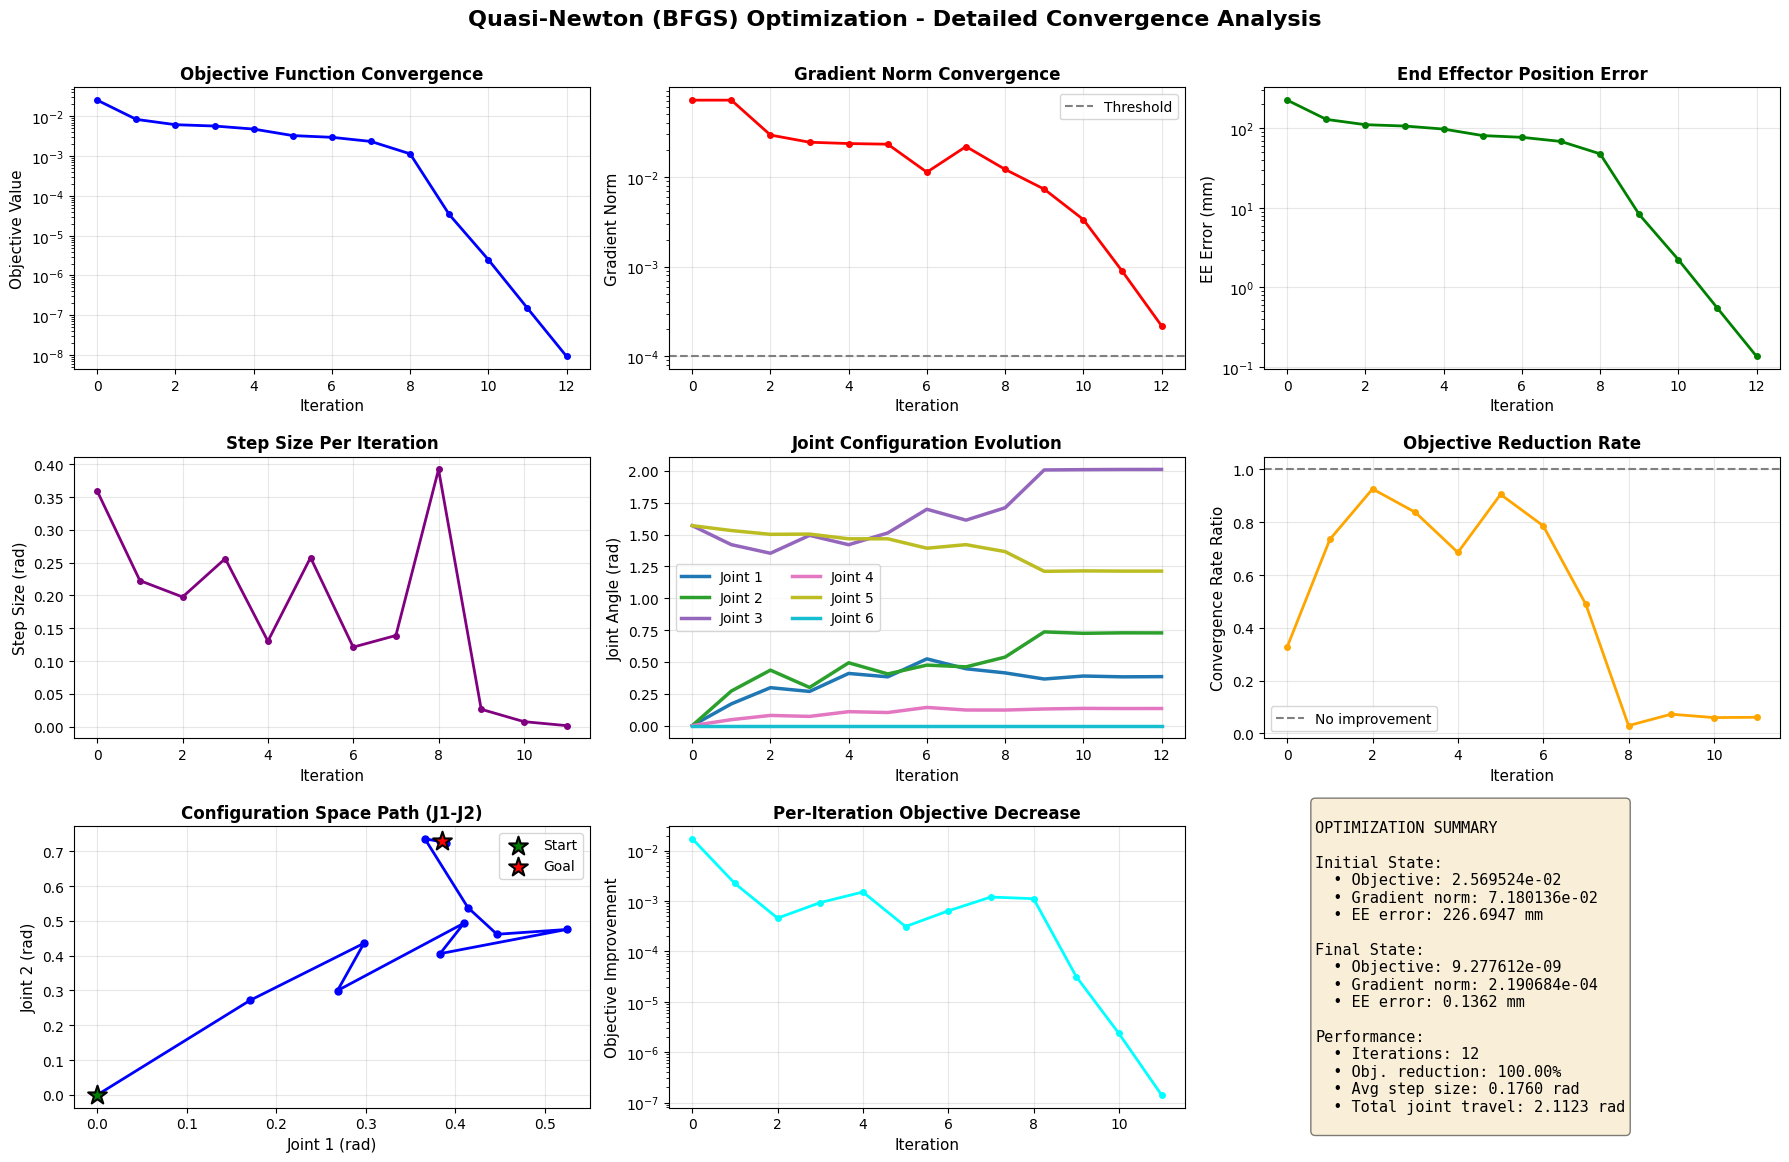

In [ ]:
target_pos = np.array([0.35, 0.15, 0.35])
start_config = x0.copy()

print(f"Target position: {target_pos}")
print(f"Start configuration: {np.round(start_config, 3)}\n")

def quasi_newton_with_metrics(model, data, x0, goal_position, threshold=1e-4, max_iter=100):
    xk = np.array(x0)
    hk = np.eye(len(x0))
    
    obj_history = []
    gradient_norms = []
    step_sizes = []
    ee_errors = []
    joint_configs = []
    
    def f(x):
        set_joint_positions(model, data, x)
        ee_pos = get_end_effector_position(model, data)
        diff = ee_pos - goal_position
        return 0.5 * np.dot(diff, diff)
    
    def grad(x):
        return gradient_fd(f, x)
    
    set_joint_positions(model, data, xk)
    ee_pos = get_end_effector_position(model, data)
    obj_history.append(f(xk))
    gradient_norms.append(np.linalg.norm(grad(xk)))
    ee_errors.append(np.linalg.norm(ee_pos - goal_position))
    joint_configs.append(xk.copy())
    step_sizes.append(0)
    
    for i in range(max_iter):
        g = grad(xk)
        g_norm = np.linalg.norm(g)
        obj_val = f(xk)
        
        if g_norm < threshold:
            print(f"Converged at iteration {i}")
            break
        
        pk = -hk @ g
        
        def zoom_func(phi, D, a_low, a_high, max_iter=1000):
            for _ in range(max_iter):
                a_j = (a_low + a_high) / 2
                if (((phi(a_j) > phi(0) + c_1*a_j*D(0))) or phi(a_j) >= phi(a_low)):
                    a_high = a_j
                else:
                    if np.abs(D(a_j)) <= c_2*np.abs(D(0)):
                        return a_j
                    if D(a_j)*(a_high - a_low) >= 0:
                        a_high = a_low
                    a_low = a_j
            return a_j
        
        def phi(alpha):
            return f(xk + alpha * pk)
        
        def D(alpha):
            return np.dot(grad(xk + alpha*pk), pk)
        
        alpha = line_search(phi, D, zoom_func, a_initial=0, a_max=10.0, max_iter=1000)
        if alpha is None:
            print("Line search failed")
            break
        
        xk_old = xk
        xk = xk + alpha * pk
        
        sk = xk - xk_old
        yk = grad(xk) - grad(xk_old)
        hk = bfgs_hessian(hk, sk, yk)
        
        set_joint_positions(model, data, xk)
        ee_pos = get_end_effector_position(model, data)
        obj_history.append(f(xk))
        gradient_norms.append(g_norm)
        ee_errors.append(np.linalg.norm(ee_pos - goal_position))
        joint_configs.append(xk.copy())
        step_sizes.append(alpha * np.linalg.norm(pk))
    
    return xk, obj_history, gradient_norms, step_sizes, ee_errors, joint_configs

optimal_joints, obj_hist, grad_norms, step_sizes, ee_errors, joint_traj = quasi_newton_with_metrics(
    model, data, start_config, target_pos, threshold=1e-4, max_iter=100
)

print(f"Total iterations: {len(obj_hist) - 1}")
print(f"Final objective: {obj_hist[-1]:.8e}")
print(f"Final gradient norm: {grad_norms[-1]:.8e}")
print(f"Final EE error: {ee_errors[-1]*1000:.4f}mm")

fig = plt.figure(figsize=(18, 12))

ax1 = plt.subplot(3, 3, 1)
ax1.semilogy(obj_hist, 'b-o', linewidth=2, markersize=4)
ax1.set_xlabel('Iteration', fontsize=11)
ax1.set_ylabel('Objective Value', fontsize=11)
ax1.set_title('Objective Function Convergence', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 3, 2)
ax2.semilogy(grad_norms, 'r-o', linewidth=2, markersize=4)
ax2.axhline(y=1e-4, color='gray', linestyle='--', label='Threshold')
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('Gradient Norm', fontsize=11)
ax2.set_title('Gradient Norm Convergence', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(3, 3, 3)
ax3.semilogy(np.array(ee_errors) * 1000, 'g-o', linewidth=2, markersize=4)
ax3.set_xlabel('Iteration', fontsize=11)
ax3.set_ylabel('EE Error (mm)', fontsize=11)
ax3.set_title('End Effector Position Error', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(3, 3, 4)
ax4.plot(step_sizes[1:], 'purple', linewidth=2, marker='o', markersize=4)
ax4.set_xlabel('Iteration', fontsize=11)
ax4.set_ylabel('Step Size (rad)', fontsize=11)
ax4.set_title('Step Size Per Iteration', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(3, 3, 5)
joint_traj_array = np.array(joint_traj)
colors = plt.cm.tab10(np.linspace(0, 1, 6))
for i in range(6):
    ax5.plot(joint_traj_array[:, i], linewidth=2.5, label=f'Joint {i+1}', color=colors[i])
ax5.set_xlabel('Iteration', fontsize=11)
ax5.set_ylabel('Joint Angle (rad)', fontsize=11)
ax5.set_title('Joint Configuration Evolution', fontsize=12, fontweight='bold')
ax5.legend(ncol=2)
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(3, 3, 6)
if len(obj_hist) > 1:
    convergence_rate = []
    for i in range(1, len(obj_hist)):
        if obj_hist[i-1] > 0:
            rate = obj_hist[i] / obj_hist[i-1]
            convergence_rate.append(rate)
    ax6.plot(convergence_rate, 'orange', linewidth=2, marker='o', markersize=4)
    ax6.axhline(y=1.0, color='gray', linestyle='--', label='No improvement')
    ax6.set_xlabel('Iteration', fontsize=11)
    ax6.set_ylabel('Convergence Rate Ratio', fontsize=11)
    ax6.set_title('Objective Reduction Rate', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

ax7 = plt.subplot(3, 3, 7)
ax7.plot(joint_traj_array[:, 0], joint_traj_array[:, 1], 'b-o', linewidth=2, markersize=5)
ax7.scatter(joint_traj_array[0, 0], joint_traj_array[0, 1], 
           c='green', s=200, marker='*', label='Start', zorder=5, edgecolors='black', linewidth=1.5)
ax7.scatter(joint_traj_array[-1, 0], joint_traj_array[-1, 1], 
           c='red', s=200, marker='*', label='Goal', zorder=5, edgecolors='black', linewidth=1.5)
ax7.set_xlabel('Joint 1 (rad)', fontsize=11)
ax7.set_ylabel('Joint 2 (rad)', fontsize=11)
ax7.set_title('Configuration Space Path (J1-J2)', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

ax8 = plt.subplot(3, 3, 8)
if len(obj_hist) > 1:
    improvements = []
    for i in range(1, len(obj_hist)):
        improvement = obj_hist[i-1] - obj_hist[i]
        improvements.append(improvement)
    ax8.semilogy(np.abs(improvements), 'cyan', linewidth=2, marker='o', markersize=4)
    ax8.set_xlabel('Iteration', fontsize=11)
    ax8.set_ylabel('Objective Improvement', fontsize=11)
    ax8.set_title('Per-Iteration Objective Decrease', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3)

ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')
summary_text = f"""
OPTIMIZATION SUMMARY

Initial State:
  • Objective: {obj_hist[0]:.6e}
  • Gradient norm: {grad_norms[0]:.6e}
  • EE error: {ee_errors[0]*1000:.4f} mm

Final State:
  • Objective: {obj_hist[-1]:.6e}
  • Gradient norm: {grad_norms[-1]:.6e}
  • EE error: {ee_errors[-1]*1000:.4f} mm

Performance:
  • Iterations: {len(obj_hist) - 1}
  • Obj. reduction: {(1 - obj_hist[-1]/obj_hist[0])*100:.2f}%
  • Avg step size: {np.mean(step_sizes[1:]):.4f} rad
  • Total joint travel: {np.sum(step_sizes[1:]):.4f} rad
"""
ax9.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', 
         facecolor='wheat', alpha=0.5))

plt.suptitle('Quasi-Newton (BFGS) Optimization - Detailed Convergence Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()